In [1]:
import sys
import os
import hydra
from omegaconf import OmegaConf

# add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# initialize hydra

In [2]:
hydra.initialize(config_path="../config", version_base="1.1")

# Choose which config to load
config_name = "config"  # Change this to use a different config
print(f"Loading config: {config_name}")

# Load the config
cfg = hydra.compose(
    config_name=config_name, 
    overrides=["experiment=ops_small"]
)

# Display the loaded config
print(OmegaConf.to_yaml(cfg))

Loading config: config
dataset:
  _target_: datasets.ops.OPSDataset
  set_size: ${experiment.set_size}
  seed: ${seed}
  data_shape:
  - 2
  - 64
  - 64
  prob_spatial: ${experiment.spatial_prob}
  spatial_kernel_width: 10
  replace: true
  pert_embedding_dim: ${experiment.pert_embedding_dim}
encoder:
  _target_: encoder.conv_gnn.ConvDistributionEncoder
  in_channels: ${dataset.data_shape[0]}
  hidden_channels: 32
  out_channels: 32
  hidden_dim: ${experiment.hidden_dim}
  latent_dim: ${experiment.latent_dim}
  num_layers: 2
  kernel_size: 3
  height: ${dataset.data_shape[1]}
  width: ${dataset.data_shape[2]}
  pool_type: mean
  agg_type: mean
model:
  _target_: model.unet_large.ContextUnetLarge
  in_channels: ${dataset.data_shape[0]}
  n_feat: 384
  latent_dim: ${experiment.latent_dim}
  image_size: ${dataset.data_shape[1]}
generator:
  _target_: generator.ddpm.DDPM
  model: ${model}
  betas:
  - 0.0001
  - 0.02
  n_T: 400
  drop_prob: 0.1
  noise_shape: ${dataset.data_shape}
optimize

In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'ops_c66c5547594b6499ce918c9be2faac34' in c['name'] 
]   


In [4]:
cfgs

[{'name': 'ops_c66c5547594b6499ce918c9be2faac34',
  'dir': '../outputs/ops_c66c5547594b6499ce918c9be2faac34',
  'config': {'dataset': {'_target_': 'datasets.ops.OPSDataset', 'set_size': '${experiment.set_size}', 'seed': '${seed}', 'data_shape': [2, 64, 64], 'prob_spatial': '${experiment.spatial_prob}', 'spatial_kernel_width': 10, 'replace': True, 'pert_embedding_dim': '${experiment.pert_embedding_dim}'}, 'encoder': {'_target_': 'encoder.conv_gnn.ConvDistributionEncoder', 'in_channels': '${dataset.data_shape[0]}', 'hidden_channels': 32, 'out_channels': 32, 'hidden_dim': '${experiment.hidden_dim}', 'latent_dim': '${experiment.latent_dim}', 'num_layers': 2, 'kernel_size': 3, 'height': '${dataset.data_shape[1]}', 'width': '${dataset.data_shape[2]}', 'pool_type': 'mean', 'agg_type': 'mean'}, 'model': {'_target_': 'model.unet_large.ContextUnetLarge', 'in_channels': 2, 'n_feat': 384, 'latent_dim': 128, 'image_size': 64}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'b

In [5]:
! ls ../outputs/ops_c66c5547594b6499ce918c9be2faac34

checkpoint_epoch_1.pt  config.yaml


In [6]:
import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/checkpoint_epoch_1.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

enc, gen = instantiate_and_load_model(cfgs[0])

In [7]:
dataset = hydra.utils.instantiate(cfg.dataset)


Dataset initialized:
Total tiles: 38942
Total images: 20872480
Available perturbations: 4961
Holdout perturbations: {'MAD2L1', 'PCNA', 'DONSON', 'BIRC5', 'UBE2I', 'RPA1', 'RRM1', 'RACGAP1'}


In [8]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=2)

for batch in dl:
    print(batch['samples'].shape)
    break


torch.Size([2, 64, 2, 64, 64])


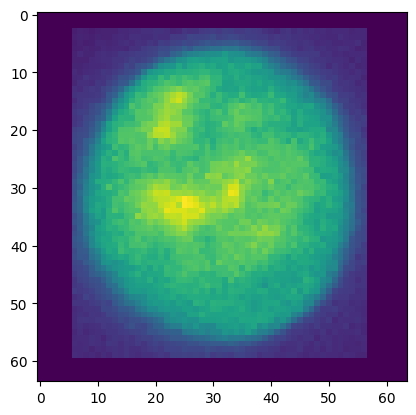

In [9]:
# show image 
import matplotlib.pyplot as plt
plt.imshow(batch['samples'][0, 5, 0].cpu().numpy())
plt.show()


In [10]:
import numpy as np
from tqdm import tqdm
def get_all_images_for_perturbation(dataset, perturbation_name, max_images=None, use_tqdm=False):
    """
    Efficiently retrieves all images for a specified perturbation using memory mapping.
    
    Args:
        dataset: An initialized OPSDataset instance
        perturbation_name: The name of the perturbation to retrieve
        max_images: Maximum number of images to return (None for all)
        
    Returns:
        A numpy array of all images for the perturbation
    """
    # Check if perturbation exists
    if perturbation_name not in dataset.pert_indices and perturbation_name not in dataset.heldout_pert_indices:
        available_perts = list(dataset.pert_indices.keys())
        holdout_perts = list(dataset.heldout_pert_indices.keys())
        raise ValueError(f"Perturbation '{perturbation_name}' not found. Available: {available_perts}\nHoldout: {holdout_perts}")
    
    # Get perturbation data
    if perturbation_name in dataset.pert_indices:
        pert_data = dataset.pert_indices[perturbation_name]
    else:
        pert_data = dataset.heldout_pert_indices[perturbation_name]
    
    # Collect images from all tiles
    all_images = []
    image_count = 0
    
    if use_tqdm:
        tile_iter = tqdm(pert_data)
    else:
        tile_iter = pert_data
    for tile_data in tile_iter:
        tile_idx = tile_data['tile_idx']
        local_indices = np.array(tile_data['local_indices'])
        
        # Use memory mapping to only load relevant indices
        tile_path = dataset.tile_paths[tile_idx]
        # Memory-map the file
        mmap_array = np.load(f"{tile_path}/single_cell_images.npy", mmap_mode='r')
        # Only extract the indices we need
        perturbation_images = mmap_array[local_indices]
        all_images.append(perturbation_images)
        
        image_count += len(perturbation_images)
        if max_images is not None and image_count >= max_images:
            # Trim to max_images if specified
            all_combined = np.vstack(all_images)
            return all_combined[:max_images]
    
    # Combine all images
    return np.vstack(all_images)

In [11]:
gene_labels = [
    "UBE2I", "DTL", "LRR1", "DONSON", "RRM1", "ORC1", "SMU1", "RPA1", "PCNA", "MMS22L",
    "DDB1", "POLE", "SF3B3", "PSMA4", "RBX1", "CDC45", "PSMB2", "PSMA1", "SNU13",
    "HINFP", "BIRC5", "CRNKL1", "AURKB", "RACGAP1", "PRC1", "MAD2L1", "TTK", "MTBP",
    "ESPL1"
]


In [12]:
# select random control perts


In [12]:
# get all images for perturbation
# load all perturbations in gene_labels
pert_images = {}
for pert in gene_labels + ['nontargeting']:
    pert_images[pert] = get_all_images_for_perturbation(dataset, pert, use_tqdm=True)




100%|██████████| 38196/38196 [00:28<00:00, 1336.71it/s]


In [13]:
nucleus_size = {}
for pert in gene_labels + ['nontargeting']:
    nucleus_size[pert] = pert_images[pert][:, 0][20:-20, 20:-20].mean()
    print(pert, nucleus_size[pert])

UBE2I 1731.1501825325954
DTL 2084.513257434806
LRR1 1816.5079592099316
DONSON 1557.9863910244055
RRM1 1583.5425001880628
ORC1 1624.091903197056
SMU1 1690.2402882254817
RPA1 1631.179151863823
PCNA 1626.1755972124206
MMS22L 1679.5790958016787
DDB1 1577.8511094147816
POLE 1539.2461177170474
SF3B3 1488.8634829637308
PSMA4 1567.815015475142
RBX1 1598.5682523889766
CDC45 1488.3717034120605
PSMB2 1529.141439601015
PSMA1 1445.3573417619248
SNU13 1553.3765682987516
HINFP 1489.4048147513408
BIRC5 1784.0160025342018
CRNKL1 1576.3372405405994
AURKB 1656.3287107586425
RACGAP1 1538.5811137714363
PRC1 1559.1907099678813
MAD2L1 1520.3783180596117
TTK 1497.259603177254
MTBP 1521.5837218490572
ESPL1 1567.7556147879395
nontargeting 1393.867773242328


In [13]:
enc.to('cuda')
gen.model.to('cuda')


ContextUnetLarge(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(2, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 384, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 384, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): MaxPool2d(kerne

In [31]:
lat = lat.detach()

In [46]:
# img = torch.tensor(pert_images['UBE2I'][:4][:, :, 20:-20, 20:-20], dtype=torch.float).to('cuda')
img = batch['samples'].to('cuda').reshape(-1, 2, 64, 64) + 1
optimizer = torch.optim.Adam(gen.model.parameters(), lr=0.0001)
for _ in range(10_000):
    loss = gen.loss(img, lat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    

KeyboardInterrupt: 

In [15]:
# preprocess tiff
imgs = pert_images['UBE2I'][:1000][:, :, 20:-20, 20:-20]
imgs = imgs / 65535
imgs = 2 * imgs - 1
imgs = imgs.astype(np.float32)
imgs = torch.tensor(imgs, dtype=torch.float).unsqueeze(0).to('cuda')

In [14]:
lat = enc(batch['samples'].to('cuda'))
rec = gen.sample(lat, num_samples=10)

In [15]:
batch['samples'][0][0]

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [16]:
rec[0]

tensor([[[[-0.9845, -1.0296, -1.0089,  ..., -0.9901, -1.0062, -0.9879],
          [-0.9939, -0.9985, -1.0344,  ..., -1.0378, -1.0070, -1.0091],
          [-1.0260, -1.0102, -0.9920,  ..., -1.0054, -0.9927, -0.9955],
          ...,
          [-1.0088, -1.0027, -1.0168,  ..., -1.0021, -0.9988, -1.0278],
          [-0.9802, -1.0051, -1.0002,  ..., -1.0005, -0.9989, -0.9949],
          [-1.0177, -1.0014, -1.0390,  ..., -0.9808, -0.9890, -0.9937]],

         [[-1.0034, -1.0072, -0.9917,  ..., -0.9885, -1.0029, -1.0051],
          [-1.0097, -1.0213, -1.0255,  ..., -1.0015, -1.0282, -1.0050],
          [-0.9686, -0.9887, -1.0051,  ..., -1.0113, -0.9755, -1.0290],
          ...,
          [-0.9914, -0.9899, -0.9827,  ..., -0.9887, -0.9586, -0.9798],
          [-1.0008, -1.0015, -1.0157,  ..., -0.9999, -1.0071, -0.9832],
          [-1.0177, -0.9944, -0.9784,  ..., -1.0127, -0.9913, -0.9998]]],


        [[[-0.9914, -1.0259, -0.9979,  ..., -0.9757, -1.0074, -0.9971],
          [-1.0156, -1.0122,

In [39]:
lat

tensor([[-3.2905e-02,  3.1229e-02, -4.7846e-04, -3.2667e-02,  3.2296e-03,
          1.0854e-01,  1.0721e-02,  5.4085e-02, -5.9627e-02, -7.5318e-02,
          1.2014e-02, -9.9762e-03,  9.5149e-03, -3.9744e-03,  2.2472e-02,
         -1.2553e-02,  9.2031e-03,  4.5586e-02, -4.2565e-03, -4.5407e-02,
         -1.2254e-02, -7.3485e-02,  2.8983e-02, -4.2687e-02,  5.5752e-02,
         -1.7955e-02, -2.3181e-02, -3.9260e-02, -4.3650e-03,  8.1955e-02,
          2.2461e-02, -2.7431e-02,  3.8691e-02, -1.2713e-01, -1.3315e-02,
          4.7244e-03,  1.0465e-01,  8.7353e-03,  3.9977e-02,  5.7724e-02,
         -4.3519e-02,  1.4918e-02,  7.5502e-02,  3.7959e-02,  5.5895e-02,
          6.3041e-03, -3.2034e-02,  2.6580e-02,  9.9576e-02,  2.2713e-02,
         -1.4809e-02,  1.2564e-02,  2.8078e-02, -1.8064e-02,  1.9163e-03,
          2.2207e-02, -7.4717e-04, -3.0283e-02,  2.3023e-02,  9.1150e-03,
         -4.8132e-02, -4.9030e-02,  1.6137e-02, -2.4512e-02, -2.7731e-03,
         -1.9256e-02, -6.5150e-03, -1.

In [19]:
rec

tensor([[[[[ 0.0387,  0.0349,  0.0522,  ...,  0.0467,  0.0132,  0.0565],
           [ 0.0185,  0.0337,  0.0057,  ...,  0.0486,  0.0544,  0.0283],
           [-0.0147,  0.0325,  0.0372,  ...,  0.0139,  0.0159,  0.0471],
           ...,
           [-0.0031,  0.0509,  0.0514,  ...,  0.0574,  0.0569,  0.0056],
           [-0.0284,  0.0312,  0.0051,  ...,  0.0046,  0.0322, -0.0016],
           [-0.0136,  0.0066,  0.0223,  ...,  0.0302,  0.0258,  0.0130]],

          [[-0.0026,  0.0125,  0.0423,  ...,  0.0092,  0.0343,  0.0602],
           [ 0.0757,  0.0295,  0.0424,  ...,  0.0215,  0.0633,  0.0591],
           [ 0.0270,  0.0430,  0.0352,  ..., -0.0018,  0.0077,  0.0368],
           ...,
           [ 0.0410,  0.0259,  0.0201,  ..., -0.0129,  0.0204, -0.0057],
           [ 0.0345,  0.0433,  0.0281,  ..., -0.0094,  0.0616,  0.0467],
           [ 0.0562,  0.0404,  0.0336,  ...,  0.0339,  0.0543,  0.0248]]],


         [[[ 0.0904,  0.0426,  0.0209,  ...,  0.0335,  0.0594,  0.0264],
           [ 

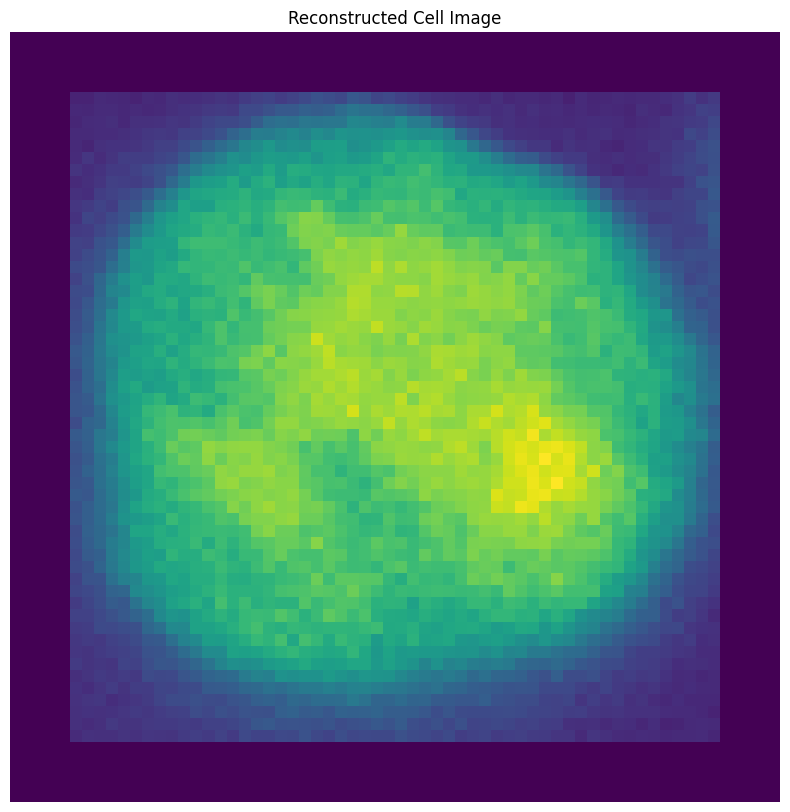

In [17]:
# show image 
import matplotlib.pyplot as plt

# Get first image from reconstructions
img = batch['samples'][0, 0, 0].detach().cpu().numpy()

# Create figure and display image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Reconstructed Cell Image')
plt.show()

In [52]:
batch['samples'].mean(axis=-1).mean(axis=-1)

tensor([[[-0.8769, -0.9748],
         [-0.9524, -0.9722],
         [-0.9292, -0.9657],
         [-0.9225, -0.9692],
         [-0.9424, -0.9761],
         [-0.9330, -0.9677],
         [-0.9424, -0.9761],
         [-0.9390, -0.9690],
         [-0.9271, -0.9021],
         [-0.9479, -0.9756],
         [-0.9493, -0.9734],
         [-0.9420, -0.9695],
         [-0.9493, -0.9734],
         [-0.9474, -0.9779],
         [-0.9476, -0.9771],
         [-0.9474, -0.9779],
         [-0.9344, -0.9791],
         [-0.9345, -0.9800],
         [-0.9344, -0.9791],
         [-0.9314, -0.9706],
         [-0.9314, -0.9706],
         [-0.9196, -0.9741],
         [-0.9463, -0.9788],
         [-0.9458, -0.9781],
         [-0.9475, -0.9817],
         [-0.9475, -0.9817],
         [-0.9465, -0.9787],
         [-0.9386, -0.9026],
         [-0.9363, -0.9803],
         [-0.9476, -0.9852],
         [-0.9404, -0.9679],
         [-0.9404, -0.9679],
         [-0.9418, -0.9775],
         [-0.9404, -0.9773],
         [-0.9

In [41]:
img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [53]:
rec.mean(axis=-1).mean(axis=-1)

tensor([[[-0.0619,  0.0660],
         [-0.0618,  0.0660],
         [-0.0617,  0.0665],
         [-0.0585,  0.0672],
         [-0.0621,  0.0662],
         [-0.0631,  0.0648],
         [-0.0615,  0.0660],
         [-0.0525,  0.0768],
         [-0.0512,  0.0710],
         [-0.0621,  0.0650]],

        [[-0.0615,  0.0655],
         [-0.0607,  0.0664],
         [-0.0531,  0.0686],
         [-0.0576,  0.0723],
         [-0.0625,  0.0649],
         [-0.0622,  0.0652],
         [-0.0590,  0.0715],
         [-0.0620,  0.0655],
         [-0.0623,  0.0652],
         [-0.0607,  0.0666]]], device='cuda:0')

In [45]:
img.min()

-0.08544132

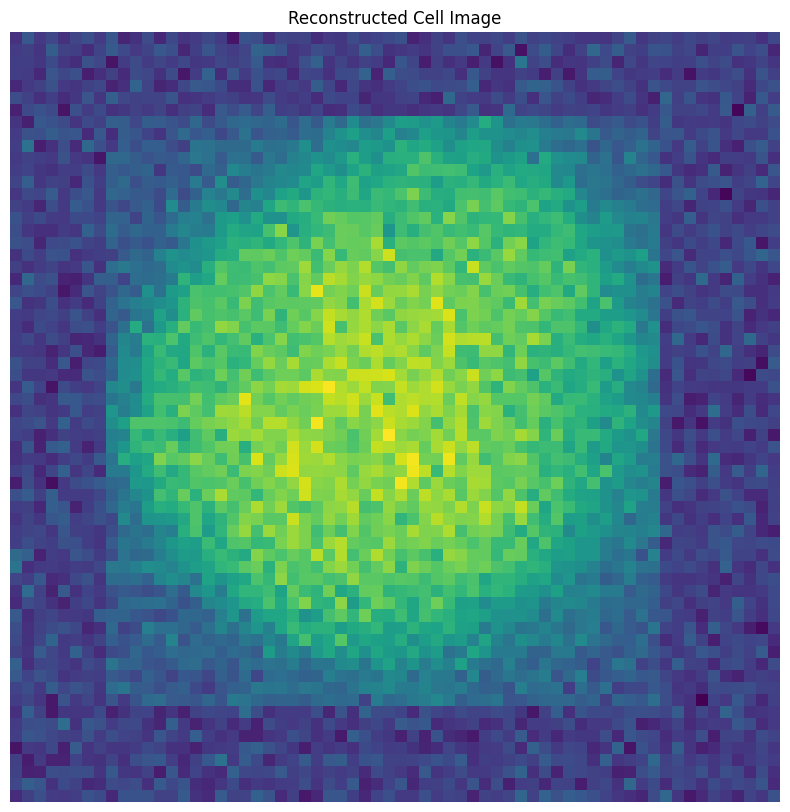

In [20]:
# show image 
import matplotlib.pyplot as plt

# Get first image from reconstructions
img = rec[0, 3, 0].detach().cpu().numpy()
# img = pert_images['UBE2I'][0][0]

# Create figure and display image
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Reconstructed Cell Image')
plt.show()


In [21]:
rec

tensor([[[[[ 1.8771e-03, -1.2213e-01,  7.6887e-02,  ...,  5.7845e-02,
             2.9574e-02,  2.0345e-02],
           [-1.1238e-01,  2.1944e-01, -2.0609e-01,  ...,  1.7195e-01,
            -2.9924e-01,  2.2261e-02],
           [-2.3575e-02,  1.3205e-01,  6.4854e-02,  ...,  1.5508e-01,
             2.8625e-01, -1.8053e-03],
           ...,
           [ 1.1722e-01,  3.0474e-01,  4.9709e-01,  ...,  9.8278e-02,
            -1.6388e-01, -3.1852e-02],
           [ 8.8473e-02,  1.3375e-01,  1.7097e-01,  ..., -2.8226e-01,
             3.4569e-01, -3.4156e-02],
           [ 3.4282e-02,  5.3661e-02,  8.3473e-02,  ...,  2.4857e-02,
            -7.8745e-02, -4.9897e-02]],

          [[ 2.9874e-02,  6.2717e-03,  8.9551e-02,  ...,  5.7265e-02,
             1.0361e-02,  5.9274e-02],
           [ 3.4831e-02,  2.7389e-01, -5.4300e-02,  ...,  5.1429e-02,
             2.1770e-01, -3.7608e-02],
           [ 8.4599e-02, -1.4591e-01,  2.7671e-01,  ..., -4.5596e-02,
             8.0729e-02,  6.6357e-02],
 